In [7]:
import numpy             as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from scipy import stats
import powerlaw

C:\Users\ldonaire\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [8]:
import pickle

def write_pkl(var,name_file):
    with open(f'variables_final\\{name_file}.pkl','wb') as arquivo:
        pickle.dump(var,arquivo)

def read_pkl(name_file):
    with open(f'variables_final\\{name_file}.pkl','rb') as arquivo:
        return pickle.load(arquivo)
    
def get_code_read_pkl(code_write_pkl):
    S = code_write_pkl.split("write_pkl(")[1]
    S = S.split("'")
    return S[0][:-1] + ' = read_pkl("' + S[1] + '")'

In [4]:
# def plot2(series, legends=0,title=None):
#     if legends==0:
#         legends = ['' for _ in series]
#     layout = go.Layout(height=1000,width=1500,title=title)
#     fig = go.Figure(data=[go.Scatter(x=series[i].index, y=series[i].values, mode='lines', name=legends[i]) for i in range(len(series))], layout=layout)
#     return fig

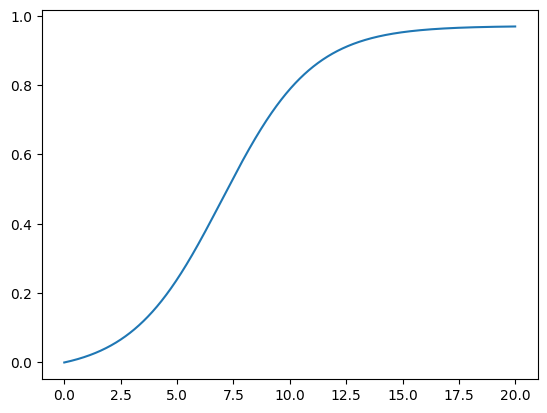

In [9]:
phi_min = 0.0 
phi_max = 1 
beta = 0.5
v_half = 7

def phi0(V, phi_min=phi_min, phi_max=phi_max, beta=beta, v_half=v_half):
    return phi_min + phi_max/(1+np.exp(-beta*(V-v_half)))

def phi(V, phi_min=phi_min, phi_max=phi_max, beta=beta, v_half=v_half):
    return phi0(V, phi_min, phi_max, beta, v_half) - phi0(0, phi_min, phi_max, beta, v_half)

x = np.arange(0,20,0.01)
y = phi(x)
plt.plot(x,y)

In [10]:
def uniform_W(k,N):
    W = k * (np.ones((N,N)) - np.eye(N))
    return W

def erdos_reny_W(k,N,p):
    W = k * np.random.binomial(1, p, size=(N, N))
    W = W - W*np.eye(N)
    return W

In [11]:
t_ref       = 0.0   # refractory period in (ms)
V_reset     = 0.0   # reset membrane potential in (mV)
def run_simulation_full(W, reset_V=True, t_sim=100, alpha=1, phi=phi, Vmax0=15, prints=False, Vmin0=0, V0=[], seed=None):
    if not pd.isnull(seed):
        np.random.seed(seed)

    #initial conditions
    phis = []
    times = []
    Vs = []

    N = len(W)
    V = np.random.uniform(Vmin0, Vmax0, size=N) 

    phi_u = np.zeros(N)    #array to store phi values
    last_spike = np.zeros(N)   # array to store last time of spike for each neuron

    # arrays to store spikes
    spk_t = [] # tempo do spike
    possible_spike_t = [] # tempo do possivel spike
    spk_id = [] # id do neuronio (0 a N-1) que teve o spike
    
    trun = 0.0 # tempo de simulacao

    times.append(trun)
    phis.append(phi_u)
    Vs.append(V)

    while (trun < t_sim):
        ALL=all(V<0.001) # sistema morre quando todos potenciais ficam abaixo de um limiar arbitrario. nesse caso, 0.001
        if ALL: 
            return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, np.array(possible_spike_t)
        
        # compute phi(T-dt)
        phi_u = phi(V)
        S = np.sum(phi_u)
        if S == 0: 
            print('S==0')
            break

        dt = np.random.exponential(scale=1/S) # jogar exponencial de taxa soma(phi)
        
        V_old = V
        V = (V)*np.exp(-alpha*dt)
        #compute V(T)
        # phi em T
        phi_u = phi(V) 

        # joga uniforme
        unif = np.random.uniform(low=0.0, high=S)
        S_new = np.sum(phi_u)
        trun += dt

        times.append(trun)
        phis.append(phi_u)
        Vs.append(V)

        possible_spike_t.append(trun)

        if unif<=S_new:
            phi_cumsum = np.cumsum(phi_u)
            neuron_id = np.where(unif<=phi_cumsum)[0][0] # acha o neuronio tal que a uniforme caiu nele

            # checking refractory period
            if last_spike[neuron_id]==0 or (trun-last_spike[neuron_id])>=t_ref:

                # updating of postsynaptic currents:
                V = V+W[neuron_id]
                last_spike[neuron_id] = trun
                # recording spike time and neuron index:
                spk_t.append(trun)
                spk_id.append(neuron_id)
                if reset_V:
                    V[neuron_id] = V_reset # Zera potencial

    return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, np.array(possible_spike_t)




def run_simulation(W, reset_V=True, t_sim=100, alpha=1, phi=phi, Vmax0=15, prints=False, Vmin0=0, V0=[], seed=None):
    if not pd.isnull(seed):
        np.random.seed(seed)

    N = len(W)
    V = np.random.uniform(Vmin0, Vmax0, size=N) 
    phi_u = np.zeros(N)    #array to store phi values
    last_spike = np.zeros(N)   # array to store last time of spike for each neuron
    trun = 0.0 # tempo de simulacao
    nspikes = 0
    while (trun < t_sim):
        ALL=all(V<0.001) # sistema morre quando todos potenciais ficam abaixo de um limiar arbitrario. nesse caso, 0.001
        if ALL: 
            return nspikes, trun

        phi_u = phi(V)
        S = np.sum(phi_u)
        if S == 0: 
            print('S==0')
            break
        
        dt = np.random.exponential(scale=1/S) # jogar exponencial de taxa soma(phi)
        V = (V)*np.exp(-alpha*dt)
        phi_u = phi(V) 
        unif = np.random.uniform(low=0.0, high=S)
        S_new = np.sum(phi_u)
        trun += dt

        if unif<=S_new:
            phi_cumsum = np.cumsum(phi_u)
            neuron_id = np.where(unif<=phi_cumsum)[0][0] # acha o neuronio tal que a uniforme caiu nele
            V = V+W[neuron_id]
            last_spike[neuron_id] = trun
            nspikes +=1
            if reset_V:
                V[neuron_id] = V_reset # Zera potencial

    return nspikes, trun

# Teste de alpha crítico

In [12]:
def fit_exp(dados):
    loc, LambdaInv = stats.expon.fit(dados,floc=0)
    return 1/LambdaInv
def test_exp(dados):
    Lambda = fit_exp(dados)
    statistic, p_value = stats.kstest(dados, 'expon', args=(0, 1/Lambda))
    return p_value


def fit_norm(dados):
    return stats.norm.fit(dados)
def test_norm(dados):
    mean, std = fit_norm(dados)
    statistic, p_value = stats.kstest(dados, 'norm', args=(mean, std))
    return p_value


def fit_lognorm(dados):
    return stats.lognorm.fit(dados, floc=0)
def test_lognorm(dados):
    shape, loc, scale = fit_lognorm(dados)
    statistic, p_value = stats.kstest(dados, 'lognorm', args=(shape, loc, scale))
    return p_value


In [13]:
def fit_powerlaw(dados, discreto=False,xmin=None):
    dados = [item for item in dados if item>0]
    if pd.isnull(xmin):
        xmin = min(dados)
        # print('xmin min dados',xmin)
    fit = powerlaw.Fit(dados, xmin=xmin, discrete=discreto)
    return fit
def test_powerlaw(dados, discreto=False,xmin=None):
    fit = fit_powerlaw(dados, discreto, xmin)
    empirical_cdf = fit.cdf()
    theoretical_cdf = fit.power_law.cdf()
    ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)
    return p_value




def fit_powerlaw_fitxmin(dados, discreto=False):
    dados = [item for item in dados if item>0]
    dados = sorted(dados)
    parameter_range = {'xmin': [None, dados[len(dados)//5] ]}
    fit = powerlaw.Fit(dados,discrete=discreto, parameter_range=parameter_range)
    return fit

def test_powerlaw_fitxmin(dados, discreto=False):
    fit = fit_powerlaw_fitxmin(dados, discreto)
    empirical_cdf = fit.cdf()
    theoretical_cdf = fit.power_law.cdf()
    ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)
    return p_value

In [14]:
def plot_powerlaw(dados, discreto=False, xmin=None):
    fit = fit_powerlaw(dados, discreto, xmin)
    fig2 = fit.plot_pdf(color='b', linewidth=2)
    fig2 = fit.plot_cdf(color='r', linewidth=2)
    fig2 = fit.plot_ccdf(color='g', linewidth=2)
    fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
    fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig2)
    fit.power_law.plot_ccdf(color='g', linestyle='--', ax=fig2)
    plt.title(f'xmin = {fit.xmin}, alpha = {fit.alpha}')
    plt.show()

In [15]:
np.random.seed(10)
W_U30 = uniform_W(1, 30)

W_U100 = uniform_W(1, 100)
W_ER100 = erdos_reny_W(1,100,0.7)

W_U1000 = uniform_W(1, 1000)
W_ER1000 = erdos_reny_W(1,1000,0.7)

## GL

In [16]:
def run_gl_v0(W, alpha, V0, n_simulations=300):
    times_death = []
    num_spikes = []
    for i in range(n_simulations):
        nspikes, trun = run_simulation(W, True, np.inf, alpha, V0=V0)
        num_spikes.append(nspikes)
        times_death.append(trun)
    return times_death, num_spikes

In [17]:
def run_gl(W, alpha, n_simulations=300):
    times_death = []
    num_spikes = []
    for i in range(n_simulations):
        # spk_t, spk_id, phis, times, Vs, trun, possible_spike_t = run_simulation(W, True, np.inf, alpha)
        # num_spikes.append(len(spk_id))
        nspikes, trun = run_simulation(W, True, np.inf, alpha)
        num_spikes.append(nspikes)
        times_death.append(trun)
    return times_death, num_spikes

def find_alpha_critical_gl(W, string_W, alpha0, step, max_tests=20, plot=True):
    alpha = alpha0
    results = {}
    for i in range(max_tests):
        durations,sizes = run_gl(W, alpha, 300)
        results[alpha] = [durations,sizes]
        if plot:
            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'GL | {string_W} | alpha={np.round(alpha,2)} | pvalue={np.round(test_exp(durations),4)}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
        if test_exp(durations) > 0.05:
            print('critical alpha')
            print(alpha)
            return alpha, durations, sizes, results
        alpha = np.round(alpha-step,2)
    print('No critical alpha found')
    return alpha, durations, sizes, results


def find_alpha_critical_gl_append(results, W, string_W, alpha0, step, max_tests=20, plot=True):
    alpha = alpha0
    # results = {}
    for i in range(max_tests):
        print()
        print('alpha', alpha)
        if alpha in results.keys():
            print(alpha,' in dicio')
            alpha = np.round(alpha-step,2)
            continue
        durations,sizes = run_gl(W, alpha, 300)
        results[alpha] = [durations,sizes]
        if plot:
            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'GL | {string_W} | alpha={np.round(alpha,2)} | pvalue={np.round(test_exp(durations),4)}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
        if test_exp(durations) > 0.05:
            print('critical alpha')
            print(alpha)
            # return alpha, durations, sizes, results
        alpha = np.round(alpha-step,2)
    print('No critical alpha found')
    results = dict(sorted(results.items(),reverse=True))
    return alpha, durations, sizes, results



### GL U 100

In [18]:
results_U100 = read_pkl('alpha_critical\\GL_U100')

In [57]:
results_U100.keys()

dict_keys([np.float64(15.8), np.float64(15.5), np.float64(15.2), np.float64(14.9), np.float64(14.6), np.float64(14.3), np.float64(14.0), np.float64(13.7), np.float64(13.4), np.float64(13.1), np.float64(12.8), np.float64(12.5), np.float64(12.2), np.float64(11.9), np.float64(11.6), np.float64(11.3), np.float64(11.0), np.float64(10.7), np.float64(10.4), np.float64(10.1), np.float64(9.8), np.float64(9.5), np.float64(9.2), np.float64(8.9), np.float64(8.6), np.float64(8.3), np.float64(8.0), np.float64(7.7), np.float64(7.4), np.float64(7.1), np.float64(6.8), np.float64(6.5), 6.2, np.float64(6.1), np.float64(6.0), np.float64(5.9), np.float64(5.8), np.float64(5.7), np.float64(5.6), np.float64(5.5), np.float64(5.4), np.float64(5.3), np.float64(5.2), np.float64(5.1), np.float64(5.0), np.float64(4.9), np.float64(4.8), np.float64(4.7), 4.6, np.float64(4.4), np.float64(4.2)])

In [22]:
# test_exp(results_U100[4.4][1])


alpha 7


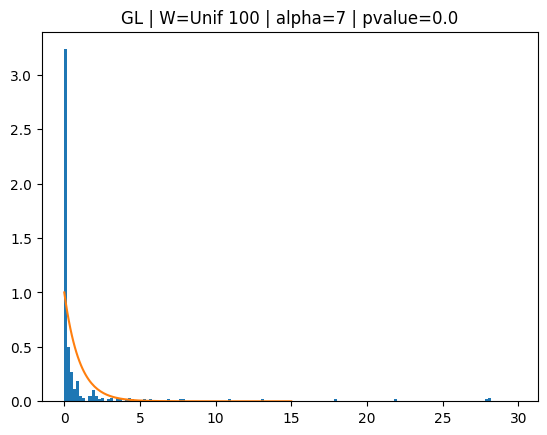

No critical alpha found


In [89]:
# alpha_U100, durations_U100, sizes_U100, results_U100 = find_alpha_critical_gl(W_U100, 5.2, 0.1, 8)
# alpha_U100, durations_U100, sizes_U100, results_U100 = find_alpha_critical_gl_append(results_U100, W_U100, 'W=Unif 100',5.2, -0.1, 10)
# alpha_U100, durations_U100, sizes_U100, results_U100 = find_alpha_critical_gl_append(results_U100, W_U100, 'W=Unif 100',4.6, 0.2, 3)
# alpha_U100, durations_U100, sizes_U100, results_U100 = find_alpha_critical_gl_append(results_U100, W_U100, 'W=Unif 100',15.8, -0.3, 10)
alpha_U100, durations_U100, sizes_U100, results_U100 = find_alpha_critical_gl_append(results_U100, W_U100, 'W=Unif 100',7, -0.3, 1)
write_pkl(results_U100,'alpha_critical\\GL_U100')

# print(test_exp(durations_U100))
# plt.hist(np.array(durations_U100)/np.mean(durations_U100), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [24]:
del [alpha_U100, durations_U100, sizes_U100, results_U100]

### V0 nao unif 0 15

In [124]:
V0 = np.random.uniform(10, 12, size=100)
results = run_gl_v0(W_U100, 10, V0)

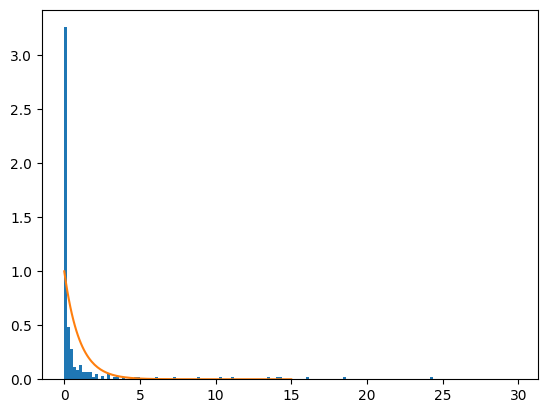

In [125]:
durations = results[0]
plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
plt.show()

### GL U 1000

In [19]:
results_U1000 = read_pkl('alpha_critical\\GL_U1000')

In [68]:
results_U1000.keys()

dict_keys([np.int64(71), np.int64(69), np.int64(67), np.int64(65), np.int64(63), np.int64(61), np.int64(59), np.int64(57), np.int64(55), 53, np.int64(52), np.int64(51), np.int64(50), np.int64(49)])


alpha 70


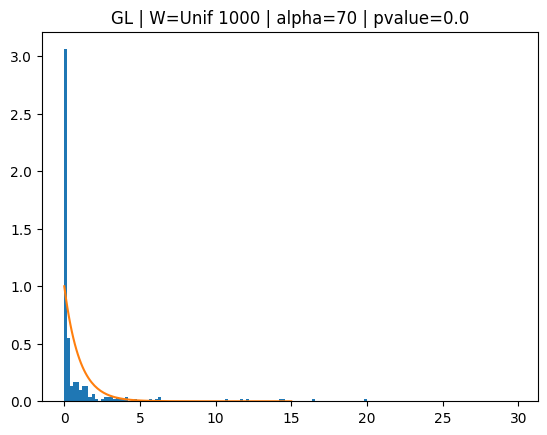

No critical alpha found


In [100]:
# alpha_U1000, durations_U1000, sizes_U1000, results_U1000 = find_alpha_critical_gl(W_U1000, 52, 1, 10)
# alpha_U1000, durations_U1000, sizes_U1000, results_U1000 = find_alpha_critical_gl_append(results_U1000, W_U1000, 'W=Unif 1000',53, -2, 10)
# alpha_U1000, durations_U1000, sizes_U1000, results_U1000 = find_alpha_critical_gl_append(results_U1000, W_U1000, 'W=Unif 1000',48, 2, 3)
# alpha_U1000, durations_U1000, sizes_U1000, results_U1000 = find_alpha_critical_gl_append(results_U1000, W_U1000, 'W=Unif 1000',73, -3, 10)
# alpha_U1000, durations_U1000, sizes_U1000, results_U1000 = find_alpha_critical_gl_append(results_U1000, W_U1000, 'W=Unif 1000',80, -10, 2)
alpha_U1000, durations_U1000, sizes_U1000, results_U1000 = find_alpha_critical_gl_append(results_U1000, W_U1000, 'W=Unif 1000',70, -10, 1)
write_pkl(results_U1000,'alpha_critical\\GL_Ul1000')
# print(results_U1000.keys())
# print(test_exp(durations_U1000))
# plt.hist(np.array(durations_U1000)/np.mean(durations_U1000), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [29]:
results_U1000.keys()

dict_keys([np.int64(71), np.int64(69), np.int64(67), np.int64(65), np.int64(63), np.int64(61), np.int64(59), np.int64(57), np.int64(55), 53, np.int64(52), np.int64(51), np.int64(50), np.int64(49), 48, np.int64(46)])

In [30]:
write_pkl(results_U1000,'alpha_critical\\GL_Ul1000')

In [ ]:
del [alpha_U1000, durations_U1000, sizes_U1000, results_U1000]

### Random

In [ ]:
# def round_keys(dicio):
#     dicio_copy = {}
#     for key,value in dicio.items():
#         dicio_copy[np.round(key,2)] = value
#     return dicio_copy

# results_U1000 = round_keys(results_U1000)
# results_U100 = round_keys(results_U100)
# resultsHK_U100 = round_keys(resultsHK_U100)

In [ ]:
# alpha_U30, durations_U30, sizes_U30, results_U30 = find_alpha_critical_gl(W_U30,'W=Unif 30', 1.3, 0.1, 4)
# write_pkl(results_U30,'alpha_critical\\GL_U30')
# print(test_exp(durations_U30))
# plt.hist(np.array(durations_U30)/np.mean(durations_U30), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [40]:
# durations_U30, sizes_U30 = run_gl(W_U30, 1)
# print(test_exp(durations_U30))
# plt.hist(np.array(durations_U30)/np.mean(durations_U30), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# durations_U100, sizes_U100 = run_gl(W_U100, 4.8)
# print(test_exp(durations_U100))
# plt.hist(np.array(durations_U100)/np.mean(durations_U100), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# durations_ER100, sizes_ER100 = run_gl(W_ER100, 3.3)
# print(test_exp(durations_ER100))
# plt.hist(np.array(durations_ER100)/np.mean(durations_ER100), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# durations_U1000, sizes_U1000 = run_gl(W_U1000, 50)
# print(test_exp(durations_U1000))
# plt.hist(np.array(durations_U1000)/np.mean(durations_U1000), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# durations_ER1000, sizes_ER1000 = run_gl(W_ER1000, 40)
# print(test_exp(durations_ER1000))
# plt.hist(np.array(durations_ER1000)/np.mean(durations_ER1000), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

## Hawkes

In [20]:
def run_hk(W, alpha, n_simulations=300):
    times_death = []
    num_spikes = []
    for i in range(n_simulations):
        print(i, pd.Timestamp.now())
        # spk_t, spk_id, phis, times, Vs, trun, possible_spike_t = run_simulation(W, False, np.inf, alpha)
        nspikes, trun = run_simulation(W, False, np.inf, alpha)
        times_death.append(trun)
        num_spikes.append(nspikes)
    return times_death, num_spikes

def find_alpha_critical_hk(W, string_W, alpha0, step, max_tests=20, plot=True):
    alpha = alpha0
    results = {}
    for i in range(max_tests):
        durations,sizes = run_hk(W, alpha, 300)
        results[alpha] = [durations,sizes]
        if plot:
            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'Hawkes | {string_W} | alpha={np.round(alpha,2)} | pvalue={np.round(test_exp(durations),4)}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
        if test_exp(durations) > 0.05:
            print('critical alpha')
            print(alpha)
            return alpha, durations, sizes, results
        alpha = np.round(alpha-step,2)
    print('No critical alpha found')
    return alpha, durations, sizes, results

def find_alpha_critical_hk_append(results, W, string_W, alpha0, step, max_tests=20, plot=True):
    alpha = alpha0
    # results = {}
    for i in range(max_tests):
        print()
        print(f'alpha = {alpha}')
        if alpha in results.keys():
            print(alpha, 'in dicio')
            alpha = np.round(alpha-step,2)
            continue
        durations,sizes = run_hk(W, alpha, 300)
        results[alpha] = [durations,sizes]
        if plot:
            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'Hawkes | {string_W} | alpha={np.round(alpha,2)} | pvalue={np.round(test_exp(durations),4)}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
        if test_exp(durations) > 0.05:
            print('critical alpha')
            print(alpha)
            return alpha, durations, sizes, results
        alpha = np.round(alpha-step,2)
    print('No critical alpha found')
    results = dict(sorted(results.items(),reverse=True))
    return alpha, durations, sizes, results


        

### HK U 100

In [21]:
resultsHK_U100 = read_pkl('alpha_critical\\HK_U100')

In [13]:
resultsHK_U100.keys()

dict_keys([np.float64(9.0), np.float64(8.8), np.float64(8.6), np.float64(8.4), np.float64(8.2), np.float64(8.0), np.float64(7.8), np.float64(7.6), np.float64(7.4), 7.2, 7, 6.8, 6.6, 6.3999999999999995, 6.199999999999999, 5.999999999999999, 5.799999999999999, 5.599999999999999, 5.399999999999999, 5.199999999999998, 4.999999999999998, 4.799999999999998])

In [ ]:
# alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100 = find_alpha_critical_hk(W_U100,'W=Unif 100', 7, 0.2, 12)
# alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100 = find_alpha_critical_hk_append(resultsHK_U100,W_U100,'W=Unif 100', 7.2, -0.2, 10)
# write_pkl(resultsHK_U100,'alpha_critical\\HK_U100')

In [ ]:
times_death = []
num_spikes = []
for i in range(300):
    print(i, pd.Timestamp.now())
    nspikes, trun = run_simulation(W_U100, False, np.inf, 4.7)
    times_death.append(trun)
    num_spikes.append(nspikes)

In [175]:
resultsHK_U100[4.7] = [times_death, num_spikes]

In [179]:
write_pkl(resultsHK_U100,'alpha_critical\\HK_U100')


alpha = 11
0 2024-11-20 15:52:28.041190
1 2024-11-20 15:52:28.049167
2 2024-11-20 15:52:28.049167
3 2024-11-20 15:52:28.050164
4 2024-11-20 15:52:28.051263
5 2024-11-20 15:52:28.052160
6 2024-11-20 15:52:28.053241
7 2024-11-20 15:52:28.054154
8 2024-11-20 15:52:28.055156
9 2024-11-20 15:52:28.056148
10 2024-11-20 15:52:28.057153
11 2024-11-20 15:52:28.057153
12 2024-11-20 15:52:28.058144
13 2024-11-20 15:52:28.059140
14 2024-11-20 15:52:28.060136
15 2024-11-20 15:52:28.060136
16 2024-11-20 15:52:28.061133
17 2024-11-20 15:52:28.062410
18 2024-11-20 15:52:28.063175
19 2024-11-20 15:52:28.064127
20 2024-11-20 15:52:28.064127
21 2024-11-20 15:52:28.065156
22 2024-11-20 15:52:28.065156
23 2024-11-20 15:52:28.067117
24 2024-11-20 15:52:28.068115
25 2024-11-20 15:52:28.068242
26 2024-11-20 15:52:28.069112
27 2024-11-20 15:52:28.070111
28 2024-11-20 15:52:28.070111
29 2024-11-20 15:52:28.071107
30 2024-11-20 15:52:28.071107
31 2024-11-20 15:52:28.071416
32 2024-11-20 15:52:28.072104
33 2024-

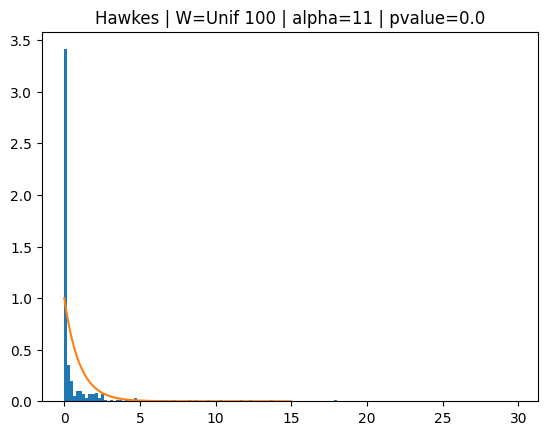


alpha = 17
0 2024-11-20 15:52:28.485288
1 2024-11-20 15:52:28.485288
2 2024-11-20 15:52:28.485288
3 2024-11-20 15:52:28.486285
4 2024-11-20 15:52:28.486285
5 2024-11-20 15:52:28.487283
6 2024-11-20 15:52:28.487408
7 2024-11-20 15:52:28.487408
8 2024-11-20 15:52:28.487408
9 2024-11-20 15:52:28.488280
10 2024-11-20 15:52:28.488492
11 2024-11-20 15:52:28.488492
12 2024-11-20 15:52:28.488492
13 2024-11-20 15:52:28.489491
14 2024-11-20 15:52:28.489709
15 2024-11-20 15:52:28.489709
16 2024-11-20 15:52:28.490489
17 2024-11-20 15:52:28.491486
18 2024-11-20 15:52:28.491486
19 2024-11-20 15:52:28.492097
20 2024-11-20 15:52:28.492483
21 2024-11-20 15:52:28.492483
22 2024-11-20 15:52:28.493275
23 2024-11-20 15:52:28.493481
24 2024-11-20 15:52:28.493481
25 2024-11-20 15:52:28.493481
26 2024-11-20 15:52:28.494478
27 2024-11-20 15:52:28.494566
28 2024-11-20 15:52:28.494566
29 2024-11-20 15:52:28.494566
30 2024-11-20 15:52:28.495522
31 2024-11-20 15:52:28.495522
32 2024-11-20 15:52:28.495522
33 2024-

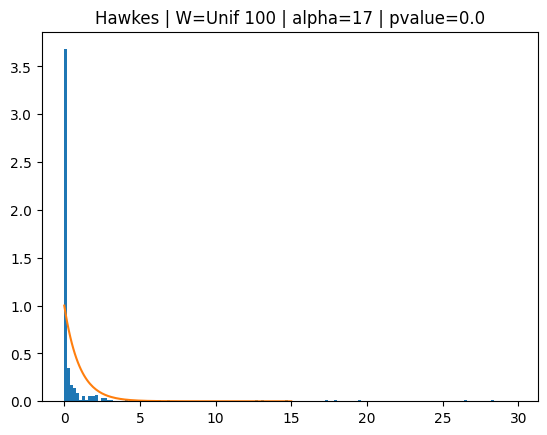

No critical alpha found


In [85]:
# alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100 = find_alpha_critical_hk_append(resultsHK_U100,W_U100,'W=Unif 100', 4.6, 0.2, 2)
# alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100 = find_alpha_critical_hk_append(resultsHK_U100,W_U100,'W=Unif 100', 4.7, 0.2, 1)
# alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100 = find_alpha_critical_hk_append(resultsHK_U100,W_U100,'W=Unif 100', 6.5, 0.1, 11)
alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100 = find_alpha_critical_hk_append(resultsHK_U100,W_U100,'W=Unif 100', 11, -6, 2)
write_pkl(resultsHK_U100,'alpha_critical\\HK_U100')

# print(test_exp(durations_U100))
# plt.hist(np.array(durations_U100)/np.mean(durations_U100), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
del [alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100]

### HK U 1000

In [43]:
# [times_death, num_spikes] = resultsHK_U1000[44]
len(times_death)

134

In [ ]:
# times_death = []
# num_spikes = []
for i in range(300-len(times_death)):
    print(i, pd.Timestamp.now())
    nspikes, trun = run_simulation(W_U1000, False, np.inf, 44)
    times_death.append(trun)
    num_spikes.append(nspikes)

In [41]:
resultsHK_U1000[44] = [times_death, num_spikes]

In [42]:
write_pkl(resultsHK_U1000,'alpha_critical\\HK_U1000')

In [ ]:
times_death = []
num_spikes = []
for i in range(300-len(times_death)):
    print(i, pd.Timestamp.now())
    nspikes, trun = run_simulation(W_U1000, False, np.inf, 43)
    times_death.append(trun)
    num_spikes.append(nspikes)


In [ ]:
resultsHK_U1000[43] = [times_death, num_spikes]
write_pkl(resultsHK_U1000,'alpha_critical\\HK_U1000')

In [22]:
resultsHK_U1000 = read_pkl('alpha_critical\\HK_U1000')

In [107]:
resultsHK_U1000.keys()

dict_keys([np.int64(90), 80, np.int64(75), np.int64(74), np.int64(73), np.int64(72), np.int64(71), np.int64(70), np.int64(69), np.int64(68), np.int64(67), np.int64(66), np.int64(65), np.int64(64), np.int64(63), np.int64(62), np.int64(61), 60, np.int64(59), np.int64(58), np.int64(57), np.int64(56), np.int64(55), np.int64(50), 48, np.int64(46), 44])

In [ ]:
# alphaHK_U1000, durationsHK_U1000, sizesHK_U1000, resultsHK_U1000 = find_alpha_critical_hk_append(resultsHK_U1000, W_U1000,'W=Unif 1000', 85, 3, 1)
alphaHK_U1000, durationsHK_U1000, sizesHK_U1000, resultsHK_U1000 = find_alpha_critical_hk_append(resultsHK_U1000, W_U1000,'W=Unif 1000', 70, -10,3)
write_pkl(resultsHK_U1000,'alpha_critical\\HK_U1000')

In [ ]:
# alphaHK_U1000, durationsHK_U1000, sizesHK_U1000, resultsHK_U1000 = find_alpha_critical_hk(W_U1000,'W=Unif 1000', 80, 5, 4)
# write_pkl(resultsHK_U1000,'alpha_critical\\HK_U1000')

# alphaHK_U1000, durationsHK_U1000, sizesHK_U1000, resultsHK_U1000 = find_alpha_critical_hk_append(resultsHK_U1000, W_U1000,'W=Unif 1000', 60, 5, 3)

print(pd.Timestamp.now())
# alphaHK_U1000, durationsHK_U1000, sizesHK_U1000, resultsHK_U1000 = find_alpha_critical_hk_append(resultsHK_U1000, W_U1000,'W=Unif 1000', 42, 3, 1)
# alphaHK_U1000, durationsHK_U1000, sizesHK_U1000, resultsHK_U1000 = find_alpha_critical_hk_append(resultsHK_U1000, W_U1000,'W=Unif 1000', 44, 3, 1)
alphaHK_U1000, durationsHK_U1000, sizesHK_U1000, resultsHK_U1000 = find_alpha_critical_hk_append(resultsHK_U1000, W_U1000,'W=Unif 1000', 75, 1, 11)
write_pkl(resultsHK_U1000,'alpha_critical\\HK_U1000')
print('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')

# alpha = 42
# 0 2024-11-14 20:03:41.227393
# 1 2024-11-14 20:36:18.535555
# 2 2024-11-14 21:50:53.307670
# 3 2024-11-14 22:55:57.611940


# print(pd.Timestamp.now())
# alphaHK_U1000, durationsHK_U1000, sizesHK_U1000, resultsHK_U1000 = find_alpha_critical_hk_append(resultsHK_U1000, W_U1000,'W=Unif 1000', 39, 3, 1)
# write_pkl(resultsHK_U1000,'alpha_critical\\HK_U1000')
# print('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa2')

# print(test_exp(durations_U1000))
# plt.hist(np.array(durations_U1000)/np.mean(durations_U1000), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# HK 1000, alpha 44
# 0 2024-11-14 23:01:47.840460
# 1 2024-11-14 23:30:05.755983
# 2 2024-11-14 23:49:08.226585
# 3 2024-11-15 00:01:14.065544
# 4 2024-11-15 00:05:53.654556
# 5 2024-11-15 00:13:14.086979
# 6 2024-11-15 01:02:10.399265
# 7 2024-11-15 01:15:57.453582
# 8 2024-11-15 01:40:58.021336
# 9 2024-11-15 02:05:17.291978
# 10 2024-11-15 02:14:43.663217
# 11 2024-11-15 02:49:49.570028
# 12 2024-11-15 02:57:11.682265
# 13 2024-11-15 03:07:26.193487
# 14 2024-11-15 03:12:23.401078
# 15 2024-11-15 03:24:13.322488
# 16 2024-11-15 03:24:13.325481
# 17 2024-11-15 03:55:48.608690
# 18 2024-11-15 04:16:55.881206
# 19 2024-11-15 04:26:14.587456
# 20 2024-11-15 04:50:54.305817
# 21 2024-11-15 05:38:53.109652
# 22 2024-11-15 06:06:17.341094
# 23 2024-11-15 06:07:10.515598
# 24 2024-11-15 06:14:30.609279
# 25 2024-11-15 06:25:39.013697
# 26 2024-11-15 06:38:04.044382
# 27 2024-11-15 06:56:10.328492
# 28 2024-11-15 08:36:02.725870
# 29 2024-11-15 09:18:48.232533
# 30 2024-11-15 09:48:24.729199
# 31 2024-11-15 10:14:23.500445
# 32 2024-11-15 10:40:31.346346
# 33 2024-11-15 10:57:42.286722
# 34 2024-11-15 11:01:54.415922
# 35 2024-11-15 11:45:46.868338
# 36 2024-11-15 11:51:27.768040
# 37 2024-11-15 12:09:30.997517
# 38 2024-11-15 12:43:45.051639
# 39 2024-11-15 13:00:09.739225
# 40 2024-11-15 13:10:11.559918
# 41 2024-11-15 13:18:03.834792
# 42 2024-11-15 13:41:09.171839
# 43 2024-11-15 15:28:23.842073
# 44 2024-11-15 16:27:19.260637
# 45 2024-11-15 16:59:31.638562
# 46 2024-11-15 17:34:53.046662
# 47 2024-11-15 17:51:44.031467
# 48 2024-11-15 18:11:53.092487
# 49 2024-11-15 18:15:01.402196
# 50 2024-11-15 20:41:31.415182
# 51 2024-11-15 21:53:46.209650
# 52 2024-11-15 22:08:05.020123
# 53 2024-11-15 22:22:33.857658
# 54 2024-11-15 22:45:34.665064
# 55 2024-11-15 23:55:27.285625
# 56 2024-11-16 01:40:48.286627
# 57 2024-11-16 01:46:39.591343
# 58 2024-11-16 01:47:22.249993
# 59 2024-11-16 02:15:59.770590
# 60 2024-11-16 03:37:06.652277
# 61 2024-11-16 05:59:42.408641
# 62 2024-11-16 06:51:18.282345
# 63 2024-11-16 07:00:21.205678
# 64 2024-11-16 07:16:00.664212
# 65 2024-11-16 08:18:23.755994
# 66 2024-11-16 08:32:17.147948
# 67 2024-11-16 08:35:19.377357
# 68 2024-11-16 08:36:11.532951
# 69 2024-11-16 09:13:59.148117
# 70 2024-11-16 09:21:20.224457
# 71 2024-11-16 10:04:21.800293
# 72 2024-11-16 10:39:46.712603
# 73 2024-11-16 11:44:21.078756
# 74 2024-11-16 11:47:58.358409
# 75 2024-11-16 13:34:42.422573
# 76 2024-11-16 13:38:29.353643
# 77 2024-11-16 14:08:33.289920
# 78 2024-11-16 14:09:45.122164
# 79 2024-11-16 14:31:56.880874
# 80 2024-11-16 14:47:20.106230
# 81 2024-11-16 15:04:17.965774

## Random - Testes PL

In [206]:
# alphaHK_U30, durationsHK_U30, sizesHK_U30, resultsHK_U30 = find_alpha_critical_hk(W_U30,'W=Unif 30', 2, 0.1, 10)
# write_pkl(resultsHK_U30,'alpha_critical\\HK_U30')
# print(test_exp(durations_U30))
# plt.hist(np.array(durations_U30)/np.mean(durations_U30), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [307]:
# dur,sizes = run_gl(W_U100, 8)
# print(test_exp(dur))
# print(test_lognorm(dur))
# print(test_powerlaw(dur))
# print(test_norm(dur))
# plt.hist(np.array(dur)/np.mean(dur), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

# print('min', min([item for item in sizes if item>0]))
# # plot_powerlaw([item for item in sizes if item>0], discreto=True)
# # plot_powerlaw([item+1 for item in sizes if item>0], discreto=True)
# # plot_powerlaw(sizes, discreto=True)
# # plot_powerlaw(sizes, discreto=True, xmin=1)
# # plot_powerlaw(dur)


In [ ]:
def fit_exp(dados):
    loc, LambdaInv = stats.expon.fit(dados)
    return 1/LambdaInv
def test_exp(dados):
    Lambda = fit_exp(dados)
    statistic, p_value = stats.kstest(dados, 'expon', args=(0, 1/Lambda))
    return p_value

In [222]:
test_exp(data)

np.float64(0.07135961590229978)

In [226]:
ks_stat, p_value = stats.kstest(data, 'powerlaw', args=(0, scale))
p_value

np.float64(nan)

In [235]:

# data = results_U1000[49][0]
# data = resultsHK_U100[7][0]
# shape,loc,scale = stats.pareto.fit(data)
# print(stats.kstest(data,'pareto',args=(shape,loc,scale)).pvalue)


# for keyy in resultsHK_U100.keys():
    # data = resultsHK_U100[keyy][0]
    # print(stats.kstest(data,'pareto',args=stats.pareto.fit(data)).pvalue)

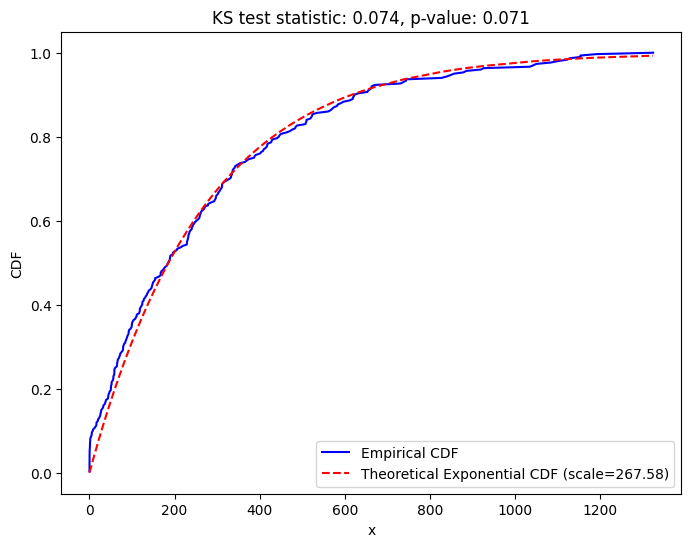

Estimated scale (1/lambda): 267.57652811623234
KS Statistic: 0.07396160690108299, p-value: 0.07135961590229978


In [224]:
data = results_U1000[49][0]

loc, scale = stats.expon.fit(data)  # Estima o parâmetro de escala
# loc = 0
# Calcular a CDF empírica dos dados
data_sorted = np.sort(data)
empirical_cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

# Calcular a CDF teórica da distribuição exponencial ajustada
exponential_cdf = stats.expon.cdf(data_sorted, loc=loc, scale=scale)

# Fazer o teste KS entre a CDF empírica e a CDF teórica da exponencial ajustada
# ks_stat, p_value = stats.ks_2samp(empirical_cdf, exponential_cdf)
ks_stat, p_value = stats.kstest(data, 'expon', args=(0, scale))

# Plot da CDF empírica e da CDF da exponencial ajustada
plt.figure(figsize=(8, 6))
plt.plot(data_sorted, empirical_cdf, label='Empirical CDF', color='blue')
plt.plot(data_sorted, exponential_cdf, linestyle='--', label=f'Theoretical Exponential CDF (scale={scale:.2f})', color='red')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()
plt.title(f'KS test statistic: {ks_stat:.3f}, p-value: {p_value:.3f}')
plt.show()

print(f"Estimated scale (1/lambda): {scale}")
print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

In [66]:
resultsHK_U100.keys()

dict_keys([7, 6.8, 6.6, 6.3999999999999995, 6.199999999999999, 5.999999999999999, 5.799999999999999, 5.599999999999999, 5.399999999999999, 5.199999999999998, 4.999999999999998, 4.799999999999998])

In [65]:
test_lognorm(resultsHK_U100[6.3999999999999995][0])

np.float64(0.18091835427234826)

In [ ]:
# data_exponencial = resultsHK_U100[4.799999999999998][0]
# data_exponencial = resultsHK_U100[4.999999999999998][0]
# data_exponencial = resultsHK_U100[5.399999999999999][0]
# data_exponencial = resultsHK_U100[6.3999999999999995][0]
# data_exponencial = resultsHK_U100[6.6][0]

for key in resultsHK_U100.keys():
    data_exponencial = resultsHK_U100[key][0]

    parameter_range = {'xmin': [None, data_exponencial[2*len(data_exponencial)//3] ]}
    # parameter_range = {}

    fit = powerlaw.Fit(data_exponencial,parameter_range=parameter_range)
    print()
    print(key)
    print('logn', test_lognorm(data_exponencial))
    print('PL x EXP')
    print(fit.distribution_compare('power_law','exponential'))
    print('PL x LogN')
    print(fit.distribution_compare('power_law','lognormal'))
    print('LogN x EXP')
    print(fit.distribution_compare('lognormal','exponential'))

    # fig2 = fit.plot_pdf(color='b', linewidth=2)
    # fig2 = fit.plot_cdf(color='r', linewidth=2)
    fig2 = fit.plot_ccdf(color='g', linewidth=2)
    # fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
    # fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig2)
    fit.power_law.plot_ccdf(color='g', linestyle='--', ax=fig2)
    plt.title(key)
    plt.show()

In [120]:
# fit = powerlaw.Fit(data_exponencial,parameter_range=parameter_range)
stats.kstest(data_exponencial,fit.cdf()[0])

KstestResult(statistic=np.float64(0.8533333333333334), pvalue=np.float64(1.2629110735032043e-30), statistic_location=np.float64(13160.878598985422), statistic_sign=np.int8(1))

In [132]:
theoretical_cdf

array([0.        , 0.00122177, 0.003211  , 0.01064567, 0.01400804,
       0.01660523, 0.03144521, 0.04953311, 0.05404663, 0.06560333,
       0.07123324, 0.08121383, 0.08384772, 0.08436237, 0.09141309,
       0.09551998, 0.09883905, 0.11209627, 0.11338573, 0.11604184,
       0.12308767, 0.12922683, 0.1294528 , 0.14561675, 0.1567921 ,
       0.15739481, 0.15844703, 0.16180146, 0.16609007, 0.17821366,
       0.17950335, 0.18415465, 0.19887937, 0.19977189, 0.20261646,
       0.20331843, 0.21271793, 0.21940592, 0.2204283 , 0.22676797,
       0.22970799, 0.23607376, 0.24112053, 0.24231501, 0.2571591 ,
       0.25813583, 0.25855192, 0.26134551, 0.2660077 , 0.26784642,
       0.27092471, 0.27313167, 0.28057008, 0.28252532, 0.28968849,
       0.30357516, 0.303761  , 0.31681002, 0.31750232, 0.31917066,
       0.32311453, 0.32977812, 0.33130013, 0.33670094, 0.33714413,
       0.33960766, 0.34016079, 0.34550729, 0.34608409, 0.34921622,
       0.35412523, 0.37368929, 0.37864027, 0.38351121, 0.39387

In [147]:
fit.power_law.cdf().__len__()


219

In [148]:
empirical_cdf[1].__len__()

300

In [152]:
list(resultsHK_U100.keys())[0]

7

In [193]:
fit.supported_distributions

{'power_law': powerlaw.Power_Law,
 'lognormal': powerlaw.Lognormal,
 'exponential': powerlaw.Exponential,
 'truncated_power_law': powerlaw.Truncated_Power_Law,
 'stretched_exponential': powerlaw.Stretched_Exponential,
 'lognormal_positive': powerlaw.Lognormal_Positive}

In [205]:
# fit = powerlaw.Stretched_Exponential(xmin=min(data_exponencial)).fit(data_exponencial)
# fit.plot_pdf(color='b', linewidth=2)
# data_exponencial

In [60]:
# def fit_powerlaw(dados, discreto=False):
#     fit = powerlaw.Fit(dados, xmin=min(dados),discrete=discreto)
#     return fit

# def test_powerlaw(dados, discreto=False):
#     fit = fit_powerlaw(dados, discreto)
#     empirical_cdf = fit.cdf()
#     theoretical_cdf = fit.power_law.cdf()
#     ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)
#     return p_value



# def fit_powerlaw_fitxmin(dados, discreto=False):
#     parameter_range = {'xmin': [None, dados[len(dados)//2] ]}
#     fit = powerlaw.Fit(dados,discrete=discreto)
#     return fit

# def test_powerlaw_fitxmin(dados, discreto=False):
#     fit = fit_powerlaw_fitxmin(dados, discreto)
#     empirical_cdf = fit.cdf()
#     theoretical_cdf = fit.power_law.cdf()
#     ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)
#     return p_value

In [312]:
# keyy = list(resultsHK_U100.keys())[0]
# for _ in range(1):

for keyy in list(resultsHK_U100.keys()):


    # data_exponencial = resultsHK_U100[keyy][0]
    data_exponencial = [item for item in resultsHK_U100[keyy][1] if item>0]

    # parameter_range = {'xmin': [None, data_exponencial[len(data_exponencial)//2] ]}
    # fit = powerlaw.Fit(data_exponencial,parameter_range=parameter_range)

    # fit = powerlaw.Fit(data_exponencial)

    print('-----------------')
    print(keyy)
    # fit = powerlaw.Fit(data_exponencial, xmin=min(data_exponencial))

    # alpha = fit.power_law.alpha
    # xmin = fit.power_law.xmin

    # empirical_cdf = fit.cdf()
    # theoretical_cdf = fit.power_law.cdf()

    # ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)

    # p_value = test_powerlaw(data_exponencial)
    p_value = test_powerlaw(data_exponencial, True)
    # fig2 = fit.plot_pdf(color='b', linewidth=2)
    # fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
    # fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
    # fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
    # fit.plot_cdf(color='g', linewidth=2, ax=fig2)
    # fit.power_law.plot_cdf(color='g', linestyle='--', ax=fig2)
    # plt.show()

    # print(f"Estimated alpha: {alpha}")
    print(f"POWELAW --- p-value: {p_value}, PL = {p_value>0.05}")
    # print(len(theoretical_cdf))
    pvlognorm = test_lognorm(data_exponencial)
    print(f"LOGNORM --- p-value: {pvlognorm}, PL = {pvlognorm>0.05}")
    pvexp = test_exp(data_exponencial)
    print(f"EXP --- p-value: {pvexp}, PL = {pvexp>0.05}")
    print()

-----------------
7
xmin min dados 1
POWELAW --- p-value: 8.37252829535952e-12, PL = False
LOGNORM --- p-value: 0.001134638370395961, PL = False
EXP --- p-value: 8.416309409142948e-32, PL = False

-----------------
6.8
xmin min dados 1
POWELAW --- p-value: 1.0051001172122527e-10, PL = False
LOGNORM --- p-value: 0.00017500846473652315, PL = False
EXP --- p-value: 4.651579686742606e-44, PL = False

-----------------
6.6
xmin min dados 1
POWELAW --- p-value: 1.8661636795549284e-08, PL = False
LOGNORM --- p-value: 0.0004143833589996189, PL = False
EXP --- p-value: 4.8823152550027254e-45, PL = False

-----------------
6.3999999999999995
xmin min dados 1
POWELAW --- p-value: 2.4758068018403678e-08, PL = False
LOGNORM --- p-value: 0.00083689610666876, PL = False
EXP --- p-value: 1.0742553207616848e-42, PL = False

-----------------
6.199999999999999
xmin min dados 1
POWELAW --- p-value: 4.596750956612726e-08, PL = False
LOGNORM --- p-value: 7.378075473753195e-06, PL = False
EXP --- p-value: 5

In [197]:
fit.distribution_compare('power_law','stretched_exponential')

(np.float64(-10.959291171812604), np.float64(0.0007151469922228298))

# OFC - Teste de distribuicoes

In [16]:
# raise Exception('Prog exp e lognorm com xmin?...')

In [112]:
def test_sizes(results, plot=False):
    for keyy in list(results.keys()):
        print()
        print(keyy)
        sizes = [item for item in results[keyy][1] if item>0]
        p_value = test_powerlaw(sizes, True, 1)
        print(p_value)
        if p_value >0.05:
            print(f"POWELAW --- p-value: {p_value}, PL = {p_value>0.05}")

        p_value2 = test_powerlaw_fitxmin(sizes, True)
        if p_value2>0.05:
            print(f"POWELAW  FITMIN--- p-value: {p_value2}, PL_F = {p_value2>0.05}")

        pvlognorm = test_lognorm(sizes)
        print(pvlognorm)
        if pvlognorm >0.05:
            print(f"LOGNORM --- p-value: {pvlognorm}, LN = {pvlognorm>0.05}")

        pvexp = test_exp(sizes)
        if pvexp >0.05:
            print(f"EXP --- p-value: {pvexp}, EXP = {pvexp>0.05}")

        if plot:
            fit = fit_powerlaw(sizes,True)
            # fig2 = fit.plot_pdf(color='b', linewidth=2)
            # fig2 = fit.plot_cdf(color='r', linewidth=2)
            # fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
            # fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig2)
            fig2 = fit.plot_ccdf(color='b', linewidth=2)
            fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2)
            plt.title(f'alpha = {keyy} | expoent = {fit.alpha}')
            plt.show()

            fit = fit_powerlaw_fitxmin(sizes,True)
            fig2 = fit.plot_ccdf(color='r', linewidth=2)
            fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2)
            plt.title(f'FIT XMIN | alpha = {keyy} | expoent = {fit.alpha} | xmin = {fit.xmin}')
            plt.show()

            plt.hist(np.array(sizes)/np.mean(sizes), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'alpha = {keyy}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()

def test_durations(results, plot=False):
    results_dist = {}
    for keyy in list(results.keys()):
        results_dist[keyy] = []
        print()
        print(keyy)
        durations = results[keyy][0]
    
        p_value = test_powerlaw(durations, False)
        if p_value >0.05:
            print(f"POWELAW --- p-value: {p_value}, PL = {p_value>0.05}")
            results_dist[keyy].append('PowerLaw')
    
        p_value2 = test_powerlaw_fitxmin(durations, False)
        if p_value2 > 0.05:
            print(f"POWELAW FITMIN --- p-value: {p_value2}, PL_F = {p_value2>0.05}")
    
        pvlognorm = test_lognorm(durations)
        if pvlognorm >0.05:
            print(f"LOGNORM --- p-value: {pvlognorm}, PL = {pvlognorm>0.05}")
            results_dist[keyy].append('LogNorm')
    
        pvexp = test_exp(durations)
        if pvexp >0.05:
            print(f"EXP --- p-value: {pvexp}, PL = {pvexp>0.05}")
            results_dist[keyy].append('Exp')
    
        if plot:
            fit = fit_powerlaw(durations,False)
            # fig2 = fit.plot_pdf(color='b', linewidth=2)
            # fig2 = fit.plot_cdf(color='r', linewidth=2)
            # fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
            # fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig2)
            fig2 = fit.plot_ccdf(color='b', linewidth=2)
            fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2)
            plt.title(f'alpha = {keyy} | expoent = {fit.alpha}')
            plt.show()

            fit = fit_powerlaw_fitxmin(durations,False)
            fig2 = fit.plot_ccdf(color='r', linewidth=2)
            fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2)
            plt.title(f'FIT XMIN | alpha = {keyy} | expoent = {fit.alpha} | xmin = {fit.xmin}')
            plt.show()

            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'alpha = {keyy}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
    return results_dist

In [113]:
results_U100.keys()

dict_keys([np.float64(18.5), np.float64(18.2), np.float64(17.9), np.float64(17.6), np.float64(17.3), np.float64(17.0), np.float64(16.7), np.float64(16.4), np.float64(16.1), np.float64(15.8), np.float64(15.5), np.float64(15.2), np.float64(14.9), np.float64(14.6), np.float64(14.3), np.float64(14.0), np.float64(13.7), np.float64(13.4), np.float64(13.1), np.float64(12.8), np.float64(12.5), np.float64(12.2), np.float64(11.9), np.float64(11.6), np.float64(11.3), np.float64(11.0), np.float64(10.7), np.float64(10.4), np.float64(10.1), np.float64(9.8), np.float64(9.5), np.float64(9.2), np.float64(8.9), np.float64(8.6), np.float64(8.3), np.float64(8.0), np.float64(7.7), np.float64(7.4), np.float64(7.1), 7, np.float64(6.8), np.float64(6.5), 6.2, np.float64(6.1), np.float64(6.0), np.float64(5.9), np.float64(5.8), np.float64(5.7), np.float64(5.6), np.float64(5.5), np.float64(5.4), np.float64(5.3), np.float64(5.2), np.float64(5.1), np.float64(5.0), np.float64(4.9), np.float64(4.8), np.float64(4.7), 

In [114]:
# res_U100 = test_durations(results_U100, False) 
# res_U1000 = test_durations(results_U1000, False)
# resHK_U100 = test_durations(resultsHK_U100, False)
resHK_U1000 = test_durations(resultsHK_U1000, False) # nao deu exp nenhum... canalhas!


90
POWELAW --- p-value: 0.5182685170344619, PL = True
Calculating best minimal value for power law fit
POWELAW FITMIN --- p-value: 0.6367231133044333, PL_F = True

80
POWELAW --- p-value: 0.5182685170344619, PL = True
Calculating best minimal value for power law fit
POWELAW FITMIN --- p-value: 0.8411180347113107, PL_F = True

75
POWELAW --- p-value: 0.5182685170344619, PL = True
Calculating best minimal value for power law fit
POWELAW FITMIN --- p-value: 0.8760631634430929, PL_F = True

74
POWELAW --- p-value: 0.2926468667924955, PL = True
Calculating best minimal value for power law fit
POWELAW FITMIN --- p-value: 0.7446629612351711, PL_F = True

73
POWELAW --- p-value: 0.17609362474930004, PL = True
Calculating best minimal value for power law fit
POWELAW FITMIN --- p-value: 0.8770877386788228, PL_F = True

72
POWELAW --- p-value: 0.4548928024568597, PL = True
Calculating best minimal value for power law fit
POWELAW FITMIN --- p-value: 0.7962607576421978, PL_F = True

71
POWELAW ---

In [ ]:
# test_sizes(results_U100, False)
# test_sizes(results_U1000, True)
# test_sizes(resultsHK_U100, False)
# test_sizes(resultsHK_U1000, False) # nao deu exp nenhum... canalhas!

In [ ]:
# RUN HK
# 100
# 5.6 - 6.5

# 1000
# 55-65

In [115]:
resHK_U1000

{np.int64(90): ['PowerLaw'],
 80: ['PowerLaw'],
 np.int64(75): ['PowerLaw'],
 np.int64(74): ['PowerLaw'],
 np.int64(73): ['PowerLaw'],
 np.int64(72): ['PowerLaw'],
 np.int64(71): ['PowerLaw'],
 np.int64(70): ['PowerLaw'],
 np.int64(69): [],
 np.int64(68): [],
 np.int64(67): ['PowerLaw'],
 np.int64(66): [],
 np.int64(65): [],
 np.int64(64): [],
 np.int64(63): [],
 np.int64(62): ['LogNorm'],
 np.int64(61): ['LogNorm'],
 60: ['LogNorm'],
 np.int64(59): ['LogNorm'],
 np.int64(58): ['LogNorm'],
 np.int64(57): [],
 np.int64(56): [],
 np.int64(55): [],
 np.int64(50): [],
 48: [],
 np.int64(46): [],
 44: ['Exp']}

### graficos tcc - DURATIONS

#### cap alpha crit

In [ ]:
###################################### GL 100
for keyy in [4.8, 4.7, 4.6]:
    durations = results_U100[keyy][0]
    # print(np.mean(durations))
    print()
    print(keyy)
    print(1/fit_exp(durations))
    plt.figure(figsize=(10,7))
    plt.hist(np.array(durations)/np.mean(durations), bins=[item/3 for item in range(9*5)], density=True)
    plt.title(f'GL 100 Neurons | alpha = {keyy} | p-value KS = {np.round(test_exp(durations),3)}')
    plt.xlabel("$\\frac{T_d}{E[T_d]}$")
    plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
    plt.show()

In [ ]:
###################################### GL 1000
for keyy in [50, 49]:
# for keyy in [49]:
    durations = results_U1000[keyy][0]
    print()
    print(keyy)
    print(1/fit_exp(durations))
    plt.figure(figsize=(10,7))
    plt.hist(np.array(durations)/np.mean(durations), bins=[item/3 for item in range(9*5)], density=True)
    plt.title(f'GL 1000 Neurons | alpha = {keyy} | p-value KS = {np.round(test_exp(durations),3)}')
    plt.xlabel("$\\frac{T_d}{E[T_d]}$")
    plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
    plt.show()

In [ ]:
##################################### HK 100

for keyy in [4.6, 4.7]:
    durations = resultsHK_U100[keyy][0]
    print()
    print(keyy)
    print(1/fit_exp(durations))
    plt.figure(figsize=(10,7))
    plt.hist(np.array(durations)/np.mean(durations), bins=[item/3 for item in range(9*5)], density=True)
    plt.title(f'Hawkes 100 Neurons | alpha = {keyy} | p-value KS = {np.round(test_exp(durations),3)}')
    plt.xlabel("$\\frac{T_d}{E[T_d]}$")
    plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
    plt.show()

In [ ]:
##################################### HK 100
    # plt.hist(np.array(durations)/np.mean(durations), bins=[item/2 for item in range(6*5)], density=True)
# for keyy in [4.6, 4.7]:

for keyy in resultsHK_U1000.keys():
    durations = resultsHK_U1000[keyy][0]
    print()
    print(keyy)
    print(1/fit_exp(durations))
    plt.figure(figsize=(10,7))
    plt.hist(np.array(durations)/np.mean(durations), bins=[item/3 for item in range(9*5)], density=True,label='$T_d$')
    plt.title(f'Hawkes 1000 Neurons | alpha = {keyy} | p-value KS = {np.round(test_exp(durations),3)}')
    plt.xlabel("$\\frac{T_d}{E[T_d]}$")
    plt.ylabel("Density")
    plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])),label='f.d.p. Exponencial')
    plt.legend()
    plt.show()

#### cap powerlaw

#### GL 100

In [93]:
# res_U100

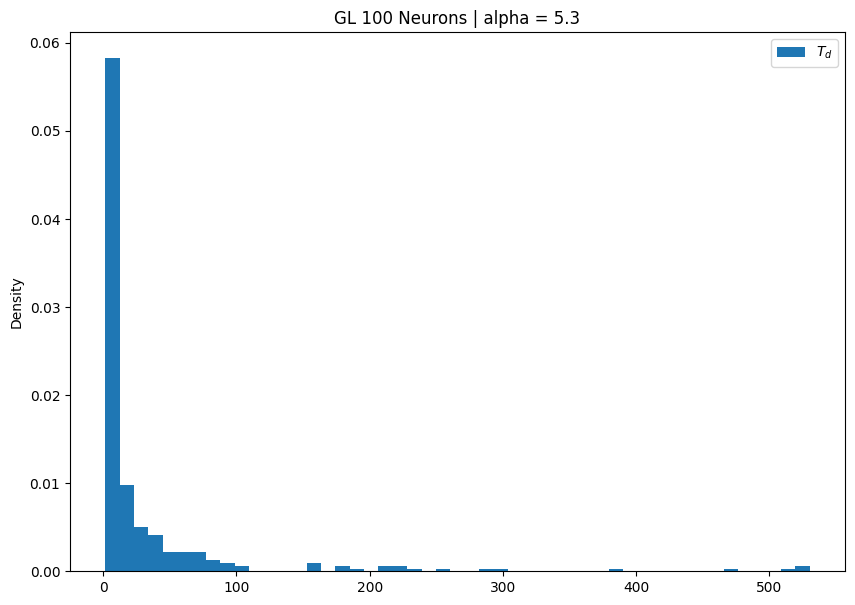

In [ ]:
###################################### GL 100
# Exp 4.7
# LN 4.9 a 5.5
# PL 6.2+

###### LogNorm
# data_lognorm = results_U100[4.9][0]
# data_lognorm = results_U100[5.5][0]
plt.figure(figsize=(10,7))
data_lognorm = results_U100[5.3][0]
# data_lognorm = results_U100[6.5][0]
shape, loc, scale = fit_lognorm(data_lognorm)
x = np.linspace(min(data_lognorm), np.quantile(data_lognorm, 0.98), 1000)
pdf = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)
plt.hist(data_lognorm,bins= np.linspace(min(data_lognorm), np.quantile(data_lognorm, 0.98), 50),density=True,label='$T_d$')
# plt.title(f'GL 100 Neurons | alpha = {5.3} | p-value KS lognorm = {np.round(test_lognorm(data_lognorm),2)}')
plt.title(f'GL 100 Neurons | alpha = {5.3}')
plt.ylabel("Density")
plt.plot(x, pdf,label='f.d.p. Log-Normal')
plt.legend()


################# Power Law

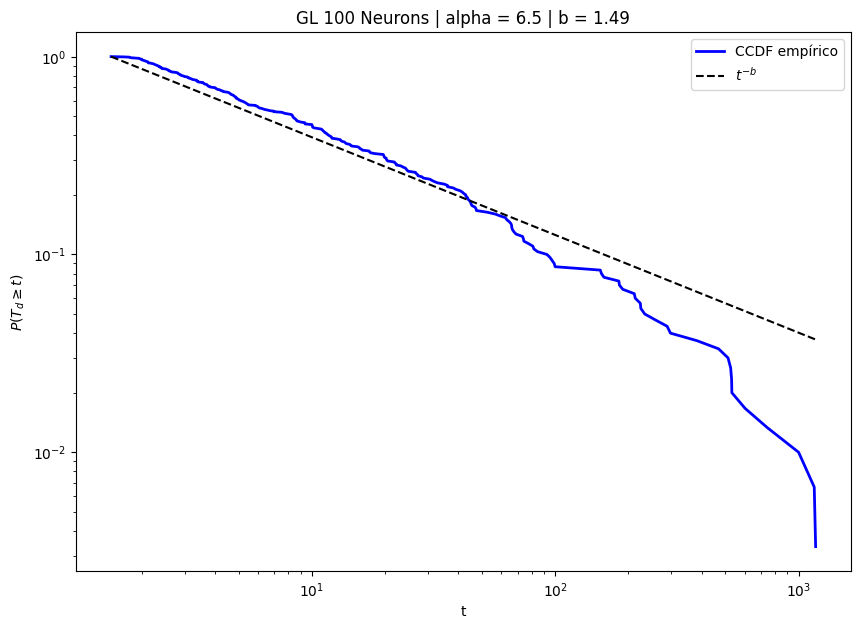

In [263]:
keyy = 6.5
durations = results_U100[keyy][0]
fit = fit_powerlaw(durations,False)
# fig2 = fit.plot_pdf(color='b', linewidth=2)
# fig2 = fit.plot_cdf(color='r', linewidth=2)
# fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
# fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig2)
plt.figure(figsize=(10,7))
fig2 = fit.plot_ccdf(color='b', linewidth=2,label='CCDF empírico')
# fig2 = fit.plot_ccdf(color='b', marker='o', linestyle='None')

# fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2)
plt.xlabel('t')
plt.ylabel('$P(T_d \geq t)$')
fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2, label='$t^{-b}$')
plt.title(f'GL 100 Neurons | alpha = {keyy} | b = {np.round(fit.alpha,2)}')
plt.legend()
plt.show()


4.6
345.98377168077604

5.3
74.04604463333199

6.5
50.303204179317056


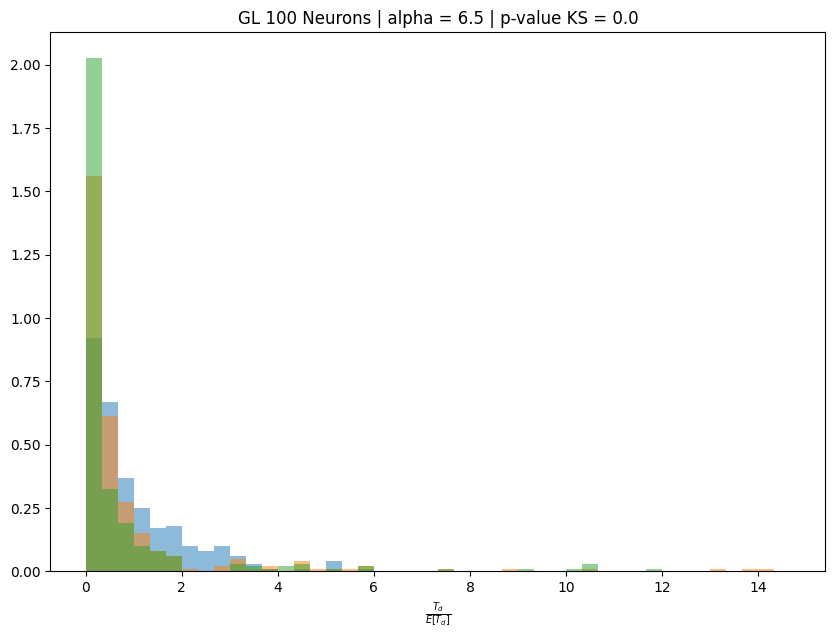

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel("$\\frac{T_d}{E[T_d]}$")
plt.title(f'GL 100 Neurons')
for keyy in [4.6, 5.3, 6.5]:
    durations = results_U100[keyy][0]
    # print(np.mean(durations))
    print()
    print(keyy)
    print(1/fit_exp(durations))
    plt.hist(np.array(durations)/np.mean(durations), bins=[item/3 for item in range(9*5)], density=True,alpha=0.5)
    # plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
    # plt.show()

### Colapse

In [119]:
def colapse_powerlaw(results,N=100,CX=1):
    # print()
    # print()
    # print()
    # print('START')
    expoents_pl = {}
    xmin_pl = {}
    collapse_pl = {} 
    for keyy in list(results.keys()):
        durations = results[keyy][0]
        p_value = test_powerlaw(durations, False)
        if p_value >0.05:
            fit = fit_powerlaw(durations,False)
            # fig2 = fit.plot_ccdf(color='b', linewidth=2)
            # fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2)
            # plt.title(f'alpha = {keyy} | expoent = {fit.alpha}')
            # plt.show()
            expoents_pl[keyy] = fit.alpha
            xmin_pl[keyy] = fit.xmin
            gamma = fit.alpha - 1

            # print(f'alpha={keyy}, exp={fit.alpha}')
            
            # x_sorted = np.sort(durations)
            # y_empirical = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
            # y_empirical = fit.pdf()
            # x_rescaled = x_sorted / fit.xmin
            # y_rescaled = y_empirical * fit.xmin**fit.alpha

            # x_cdf, y_cdf = fit.cdf()
            # x_rescaled = np.array(x_cdf) / fit.xmin
            # y_rescaled = np.array(y_cdf) * fit.xmin**fit.alpha

            # x_ccdf, y_ccdf = fit.ccdf()
            # x_rescaled = np.array(x_ccdf) / np.sqrt(N)
            # y_rescaled = np.array(y_ccdf) * np.array(x_ccdf)

            # x_ccdf, y_ccdf = fit.ccdf()
            # x_ccdf, y_ccdf = fit.ccdf()
            # x_rescaled = np.array(x_ccdf) / fit.xmin 
            # y_rescaled = np.array(y_ccdf)  * fit.xmin**(fit.alpha-1) * np.sqrt(N)

            # x_ccdf, y_ccdf = fit.ccdf()
            # x_rescaled = np.array(x_ccdf) / fit.xmin
            # y_rescaled = np.array(y_ccdf) * fit.xmin**fit.alpha


            # formula gpt, deu bom
            # x_ccdf, y_ccdf = fit.ccdf()
            # x_rescaled = np.array(x_ccdf) / N**fit.alpha
            # y_rescaled = np.array(y_ccdf) * N**gamma

            # formula flavio
            x_ccdf, y_ccdf = fit.ccdf()
            x_rescaled = np.array(x_ccdf) / N**CX
            # y_rescaled = np.array(y_ccdf) * np.array(x_ccdf)**(-gamma)
            y_rescaled = np.array(y_ccdf) * np.array(x_ccdf)**(-0.5)

            collapse_pl[keyy] = [x_rescaled, y_rescaled]



            fit = fit_powerlaw(durations,False)
            plt.figure(figsize=(10,7))
            fig2 = fit.plot_ccdf(color='b', linewidth=2,label='CCDF empírico')
            plt.xlabel('t')
            plt.ylabel('$P(T_d \geq t)$')
            fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2, label='$t^{-\\beta}$')
            plt.title(f'GL 100 Neurons | alpha = {keyy} | $\\beta$ = {np.round(fit.alpha,2)}')
            plt.legend()
            plt.show()



    return [expoents_pl, xmin_pl, collapse_pl]


In [ ]:
expoents_pl, xmin_pl, collapse_pl = colapse_powerlaw(results_U100,N=100)

In [105]:
collapse_pl4.keys()

# [6.0, 11.0, 17.0]
# [7, 11.0, 17.0]

dict_keys([80, np.int64(75), np.int64(74), np.int64(73), np.int64(72), np.int64(71), np.int64(70), np.int64(67)])

In [108]:
expoents_pl, xmin_pl, collapse_pl = colapse_powerlaw(results_U100,N=100)
expoents_pl, xmin_pl, collapse_pl2 = colapse_powerlaw(results_U1000,N=1000)
expoents_pl, xmin_pl, collapse_pl3 = colapse_powerlaw(resultsHK_U100,N=100)
expoents_pl, xmin_pl, collapse_pl4 = colapse_powerlaw(resultsHK_U1000,N=1000)

17.0
11.0
7
17
11
7


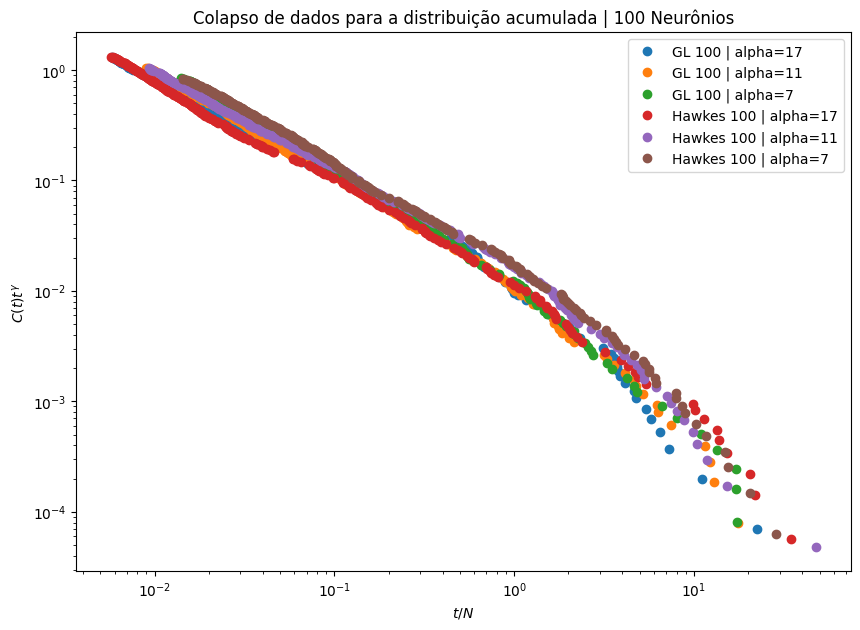

In [103]:
plt.figure(figsize=(10,7))

for key,[x,y] in collapse_pl.items():
    if key in [7.0, 11.0, 17.0]:
        print(key)
        plt.loglog(x,y,label=f"GL 100 | alpha={int(key)}",marker='o', linestyle='None')

for key,[x,y] in collapse_pl3.items():
    if key in [7.0, 11.0, 17.0]:
        print(key)
        plt.loglog(x,y,label=f"Hawkes 100 | alpha={int(key)}",marker='o', linestyle='None')

plt.title("Colapso de dados para a distribuição acumulada | 100 Neurônios")
plt.ylabel('$C(t) t^\gamma$')
plt.xlabel('$t/N$')
plt.legend()

90
80
70
90
80
70


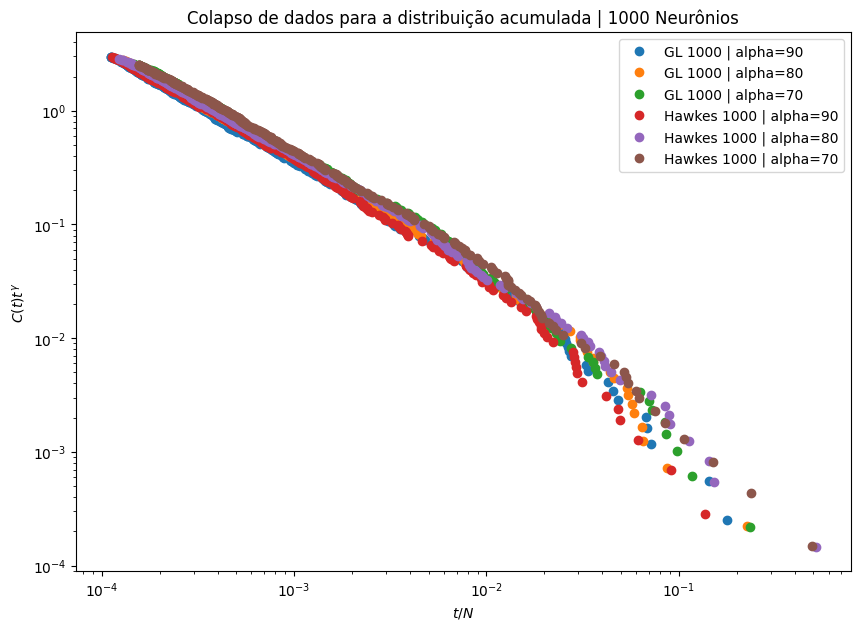

In [110]:
plt.figure(figsize=(10,7))

for key,[x,y] in collapse_pl2.items():
    if key in [70,80,90]:
        print(key)
        plt.loglog(x,y,label=f"GL 1000 | alpha={int(key)}",marker='o', linestyle='None')

for key,[x,y] in collapse_pl4.items():
    if key in [70,80,90]:
        print(key)
        plt.loglog(x,y,label=f"Hawkes 1000 | alpha={int(key)}",marker='o', linestyle='None')

plt.title("Colapso de dados para a distribuição acumulada | 1000 Neurônios")
plt.ylabel('$C(t) t^\gamma$')
plt.xlabel('$t/N$')
plt.legend()

In [ ]:

for CX in [2,1.5,1,0.5,0.25,-0.1,-0.25,-0.35,-0.5,-0.75,-1,-1.25,-1.5]:

    expoents_pl, xmin_pl, collapse_pl = colapse_powerlaw(results_U100,N=100,CX=CX)
    expoents_pl, xmin_pl, collapse_pl2 = colapse_powerlaw(results_U1000,N=1000,CX=CX)
    expoents_pl, xmin_pl, collapse_pl3 = colapse_powerlaw(resultsHK_U100,N=100,CX=CX)
    expoents_pl, xmin_pl, collapse_pl4 = colapse_powerlaw(resultsHK_U1000,N=1000,CX=CX)

    # expoents_pl
    plt.figure(figsize=(20,10))


    for key,[x,y] in collapse_pl.items():
        # plt.loglog(x,y,label=key,marker='o', linestyle='None')
        plt.loglog(x,y,label=key)
    for key,[x,y] in collapse_pl3.items():
        # plt.loglog(x,y,label=key,marker='o', linestyle='None')
        plt.loglog(x,y,label=key)



    for key,[x,y] in collapse_pl2.items():
        # plt.loglog(x,y,label=key,marker='o', linestyle='None')
        plt.loglog(x,y,label=key)
    for key,[x,y] in collapse_pl4.items():
        # plt.loglog(x,y,label=key,marker='o', linestyle='None')
        plt.loglog(x,y,label=key)
    plt.title(f'{CX}')
    plt.show()    

In [164]:
collapse_pl2.keys()

dict_keys([np.int64(71), np.int64(69), np.int64(67)])

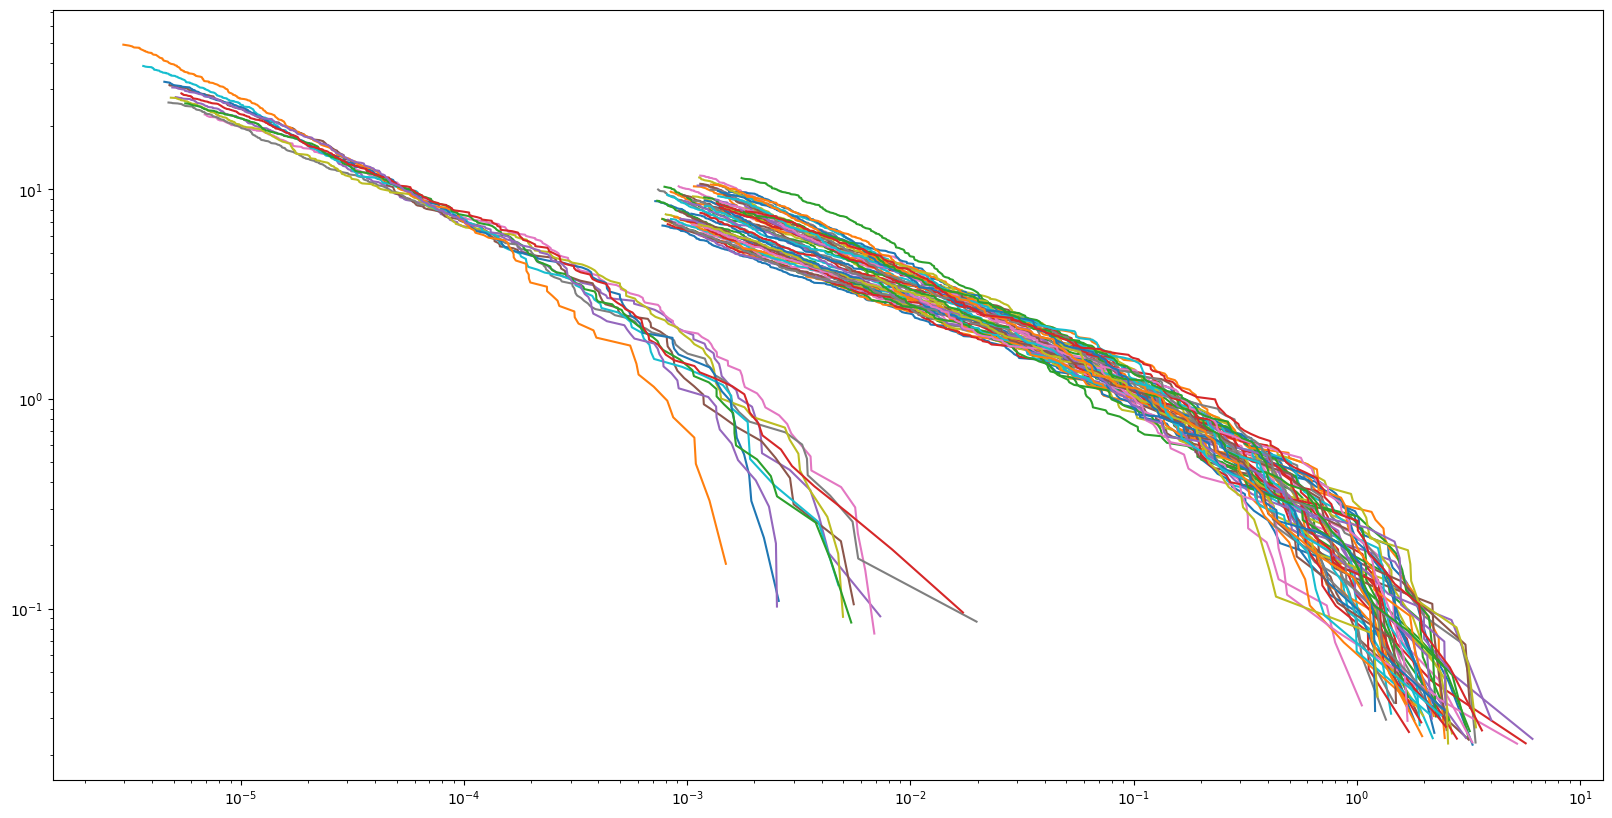

# ================

In [19]:
results_U100.keys()

dict_keys([np.float64(6.1), np.float64(6.0), np.float64(5.9), np.float64(5.8), np.float64(5.7), np.float64(5.6), np.float64(5.5), np.float64(5.4), np.float64(5.3), np.float64(5.2), np.float64(5.1), np.float64(5.0), np.float64(4.9), np.float64(4.8), np.float64(4.7), 4.6, np.float64(4.4), np.float64(4.2)])

In [ ]:
def fit_lognorm(dados):
    return stats.lognorm.fit(dados, floc=0)
def test_lognorm(dados):
    shape, loc, scale = fit_lognorm(dados)
    statistic, p_value = stats.kstest(dados, 'lognorm', args=(shape, loc, scale))
    return p_value

In [22]:
data = results_U100[5.5][0]

In [26]:
np.quantile(data, 0.9)

np.float64(105.13558848718503)

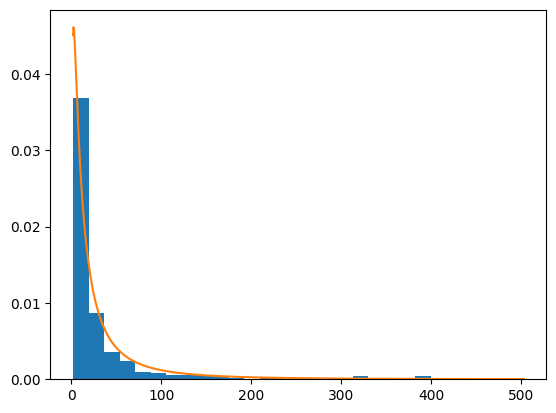

In [30]:
shape, loc, scale = fit_lognorm(data)
LambdaInv = stats.expon.fit(data)[1]

# x = np.linspace(min(data), max(data), 1000)
x = np.linspace(min(data), np.quantile(data, 0.98), 1000)
pdf = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)
# pdfexp = stats.expon.pdf(x, loc=0, scale=LambdaInv)

# plt.hist(data,bins= np.linspace(min(data), max(data), 100),density=True)
plt.hist(data,bins= np.linspace(min(data), np.quantile(data, 0.98), 30),density=True)
plt.plot(x, pdf)
# plt.plot(x, pdfexp)

In [ ]:
# GL 100
# PL 6.2+
# LogNorm 5.5-4.9
# Exp 4.7 - 4.2

In [68]:
# plt.hist(results_U100[18.5][0])

In [43]:
# np.sort(results_U1000[50.0][1])

In [37]:
# for xmin in range(1,30):
    # print()
    # print(xmin)
    # sizes = [item for item in results_U100[6.0][1] if item>xmin]
    # print(test_exp(sizes))
    # print(test_lognorm(sizes))

In [29]:
# pd.Series(np.sort(results_U100[6.0][1])).hist()
# sizes = results_U100[6.0][1]
# plt.hist(np.array(sizes)/np.mean(sizes), bins=[item/5 for item in range(15*10)], density=True)
# plt.title(f'alpha = {keyy}')
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# results_U100.keys()

dict_keys([np.float64(6.1), np.float64(6.0), np.float64(5.9), np.float64(5.8), np.float64(5.7), np.float64(5.6), np.float64(5.5), np.float64(5.4), np.float64(5.3), np.float64(5.2), np.float64(5.1), np.float64(5.0), np.float64(4.9), np.float64(4.8), np.float64(4.7)])